In [2]:
%load_ext autoreload
%autoreload 2

import copy
import os
import sys
from pathlib import Path
import subprocess
from platformdirs import user_cache_dir
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

import ms_pred.common as common
from ms_pred.dag_pred.iceberg_elucidation import candidates_from_pubchem, iceberg_prediction, load_real_spec, load_pred_spec, elucidation_over_candidates, plot_top_mols, explain_peaks, modi_finder, generate_buyable_report, load_global_config

/home/roger/miniforge3/envs/ms-main/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%cd /home/roger/ms-pred

/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred


# Global configs
Please modify the the configs in `configs/iceberg/iceberg_elucidation.yaml` accordingly; for `python_path` on molgpu, you can either
1) set up your own ms-gen environment from source
2) use Mrunali's pre-built environment, after telling conda to look in her folder with `conda config --add envs_dirs /home/mrunali/miniconda3/envs`
3) Clone Mrunali's pre-built environment into your own environment with `conda --clone` and then source that instead.

In [4]:
config = load_global_config()
common.plot_utils.set_style()

# Elucidation on Broad data

In [11]:
def broad_elucidation(spec_file, formula, real_smi=None, name="", vis_peaks=False, buyable_report=False, vis_topk=5, **kwargs):
    broad_config = copy.deepcopy(config)
    broad_config['nce'] = True # use nce for collision energy
    broad_config['merge_spec'] = True # merge spec for visualization
    for k, v in kwargs.items():
        broad_config[k] = v
    exp_spec_path = f'/home/roger/ms_collaborators/broad-Julian/spec_files/{spec_file}.ms'

    # Get candidates
    smiles = candidates_from_pubchem(formula)

    # Run ICEBERG to predict spectra
    result_path, pmz = iceberg_prediction(smiles, [10, 20, 30, 40, 50], **broad_config)

    # Compare spectrum similarity for elucidation
    topk_results = elucidation_over_candidates(result_path, exp_spec_path, precursor_mass=pmz, mol_name=name, real_smiles=real_smi, **broad_config)

    # Plot top results
    img = plot_top_mols(topk_results)

    # Visualize and explain peaks
    if vis_peaks:
        from matplotlib.backends.backend_pdf import PdfPages
        all_figs = []
        for i in range(vis_topk):
            plt.figure(figsize=(3, 2), dpi=500)
            # plt.figure(figsize=(4, 2), dpi=500)
            fig = explain_peaks(result_path, exp_spec_path, pmz, topk_results[i][0], num_peaks=9, axes=plt.gca(), **broad_config)
            plt.title(f'entropy similarity={1-topk_results[i][1]:.2f}')
            all_figs += fig
        p = PdfPages(f'{name}.pdf')
        for fig in all_figs:
            fig.savefig(p, format='pdf')
        p.close()

    # Buyable report
    if buyable_report:
        generate_buyable_report(
            [spec_file], # names
            [exp_spec_path], #exp_specs
            [{'[M+H]+': smiles}], # adduct_to_smiles
            broad_config,
            [10, 20, 30, 40, 50], topk_per_row=10, output_name=f'broad_{spec_file}_buyable_report')

    return img


## GABA-Arg isomers

[GABA-Arg] Found target mol at 1/60, ent_dist=0.502


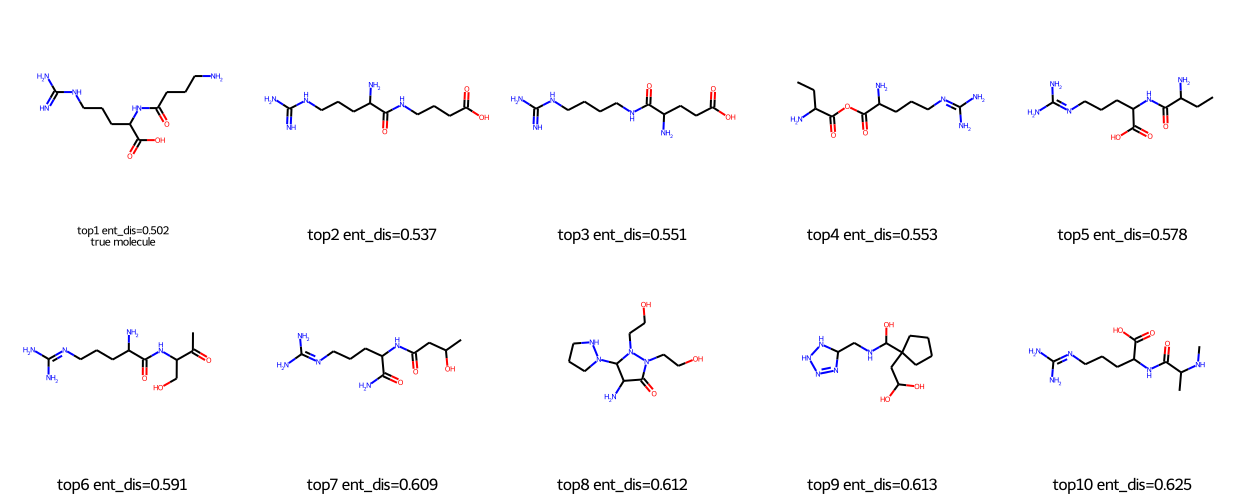

In [45]:
broad_elucidation('mxp4308', 'C10H21N5O3', r'C(C[C@@H](C(=O)O)NC(=O)CCCN)CN=C(N)N', 'GABA-Arg', False, False, vis_topk=1)

[Arg-GABA] Found target mol at 1/60, ent_dist=0.312


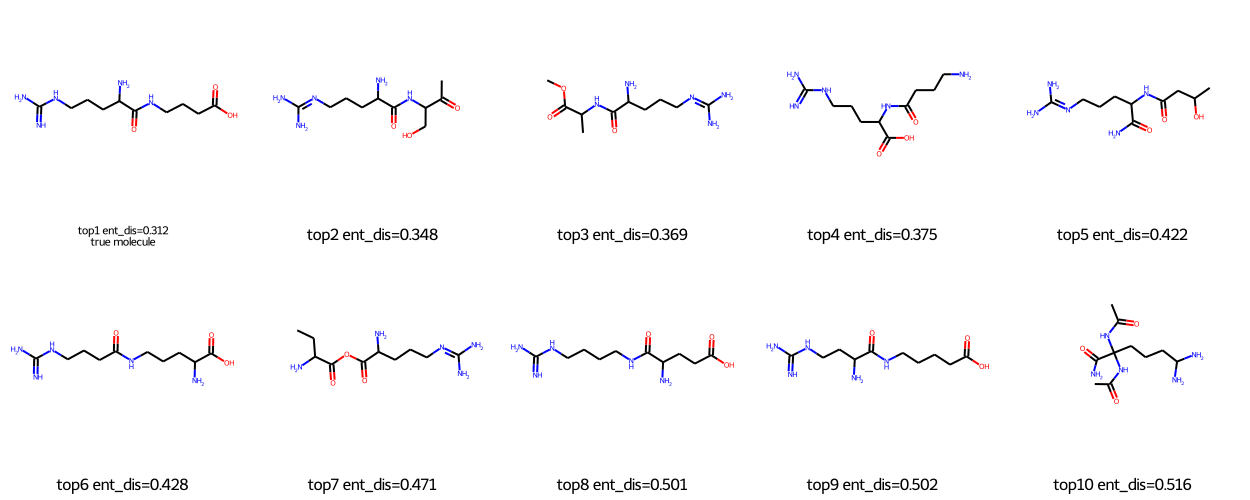

In [46]:
broad_elucidation('mxp4309', 'C10H21N5O3', r'O=C(NCCCC(O)=O)C(N)CCC/N=C(N)\N', 'Arg-GABA', False, False)

[Alanylhomoaruginine] Found target mol at 1/60, ent_dist=0.408


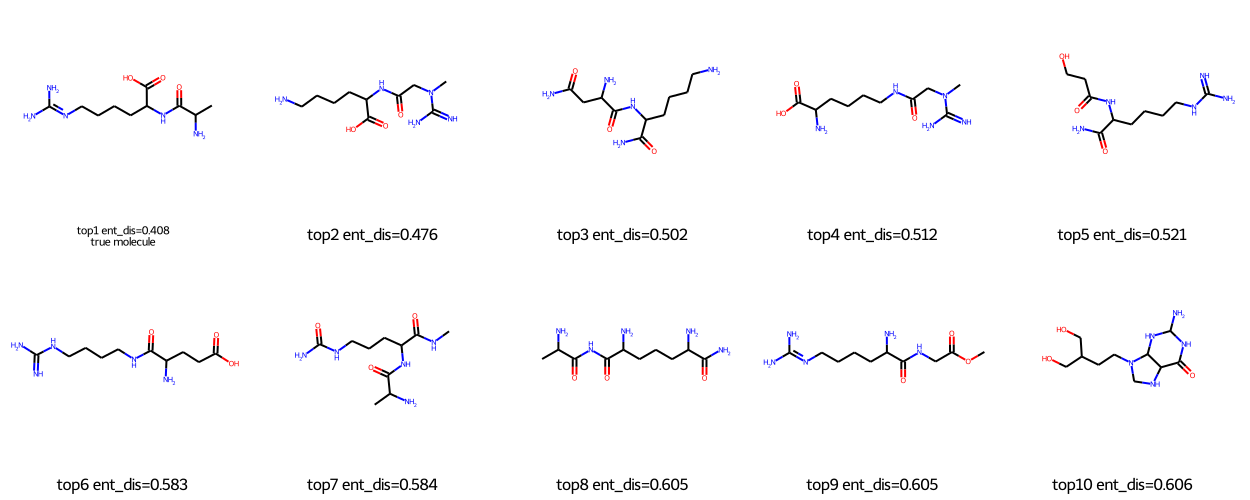

In [47]:
broad_elucidation('mxp4155', 'C10H21N5O3', r'C[C@@H](C(=O)N[C@@H](CCCCN=C(N)N)C(=O)O)N', 'Alanylhomoaruginine', False, False)

[2-(2-aminobutanamido)-5- [(diaminomethylidene)amino]pentanoic acid] Found target mol at 1/60, ent_dist=0.351


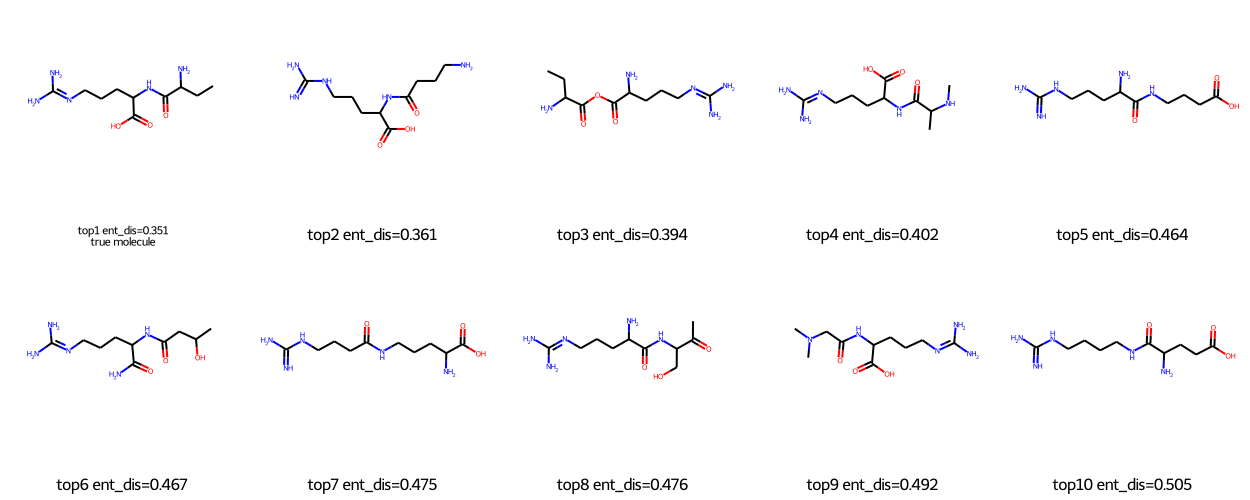

In [48]:
broad_elucidation('mxp4156', 'C10H21N5O3', r'N/C(N)=N\CCCC(C(O)=O)NC(C(N)CC)=O', '2-(2-aminobutanamido)-5- [(diaminomethylidene)amino]pentanoic acid', False, False)

[2-amino-5-{4 [(diaminomethylidene)amino]butanamido}pentanoic acid] Found target mol at 1/60, ent_dist=0.255


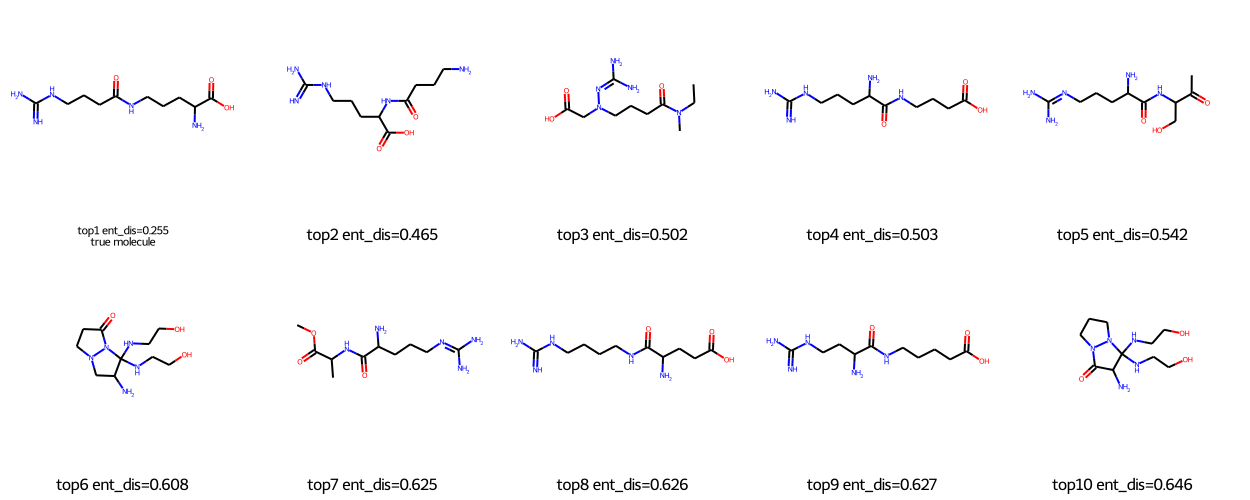

In [49]:
broad_elucidation('mxp4157', 'C10H21N5O3', r'O=C(O)C(N)CCCNC(CCC/N=C(N)\N)=O', '2-amino-5-{4 [(diaminomethylidene)amino]butanamido}pentanoic acid', False, False)

## GABA-Arg volcano plot

In [7]:
volcano_df = pd.read_excel('/home/roger/ms_collaborators/broad-Julian/gaba_arg_2014_cohort_volcano_plot.xlsx')
volcano_df

,Method,Compound,MZ,RT,HMDB ID,Metabolite,beta.TBM_v_control,pVAL.TBM_v_control,beta.alive_v_dead,pVAL.alive_v_dead,qVAL.alive_v_dead,qVAL.TBM_v_control
0,HILIC-pos,QI6404,260.171735,9.881133,NaN,GABA-Arg (TF21),-2.844136,7.433057e-08,-1.235377,0.073579,0.457865,4.445741e-07
1,HILIC-pos,QI80,126.136773,7.551833,Internal Standard,valine-d8,0.002747,9.155590e-01,-0.000280,0.992907,0.764442,4.561314e-01
2,HILIC-pos,QI65,174.136678,6.827750,Internal Standard,phenylalanine-d8,0.055806,1.822909e-02,0.037337,0.227946,0.503279,3.293991e-02
3,HILIC-pos,TF1,126.102904,9.638652,HMDB00898,1-methylhistamine,0.939785,9.139113e-03,-0.262364,0.607158,0.663139,1.846503e-02
4,HILIC-pos,TF2,137.071102,8.283497,HMDB00699,1-methylnicotinamide,1.765881,1.120400e-07,0.327102,0.381530,0.577584,6.478071e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
10887,HILIC-pos,QI14182,797.654612,7.019667,NaN,NaN,0.197468,2.742888e-01,0.209858,0.480004,0.616341,2.332072e-01
10888,HILIC-pos,QI14183,797.742620,1.549767,NaN,NaN,0.133182,6.681421e-01,0.073534,0.859045,0.735991,3.839247e-01
10889,HILIC-pos,QI14188,798.542440,5.405750,NaN,NaN,0.727282,5.003844e-02,0.304958,0.554444,0.646478,7.330440e-02
10890,HILIC-pos,QI14193,798.682830,2.047033,NaN,NaN,1.095707,9.655681e-04,-0.128039,0.785165,0.717568,2.551317e-03


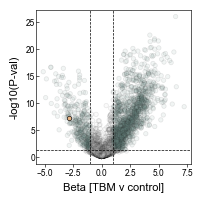

In [49]:
beta_values = volcano_df['beta.TBM_v_control']
p_values = volcano_df['pVAL.TBM_v_control']

# Convert p-values to -log10 scale
neg_log_p = -np.log10(p_values)

# Define significance thresholds
beta_threshold = 1.0  # Effect size threshold
p_threshold = 0.05  # P-value threshold
neg_log_p_threshold = -np.log10(p_threshold)

# Define colors based on significance criteria
colors = np.where((np.abs(beta_values) > beta_threshold) & (neg_log_p > neg_log_p_threshold), '#7C9D97', '#D7D7D7')

# Plot volcano plot
plt.figure(figsize=(2, 2))
plt.scatter(beta_values, neg_log_p, c=colors, alpha=0.1, edgecolors='k', linewidths=0.5, s=10)

# Find and highlight the entry of interested
idx = volcano_df[volcano_df['Compound'] == 'QI6404'].index
plt.scatter(beta_values[idx], neg_log_p[idx], c='#E9B382', alpha=1, edgecolors='k', linewidths=0.5, s=10)

# Add threshold lines
plt.axhline(y=neg_log_p_threshold, linestyle='--', color='black', linewidth=0.5, label=f'p = {p_threshold}')
plt.axvline(x=-beta_threshold, linestyle='--', color='black', linewidth=0.5, label=f'Beta = ±{beta_threshold}')
plt.axvline(x=beta_threshold, linestyle='--', linewidth=0.5, color='black')

# Labels and title
plt.xlabel('Beta [TBM v control]')
plt.ylabel('-log10(P-val)')
# plt.title('Volcano Plot for Regression Coefficients')
# plt.grid(True)

# Show plot
plt.savefig('tbm_volcano.pdf', bbox_inches="tight")

# Hercynine

[Hercynine] Found target mol at 4/8413, ent_dist=0.431


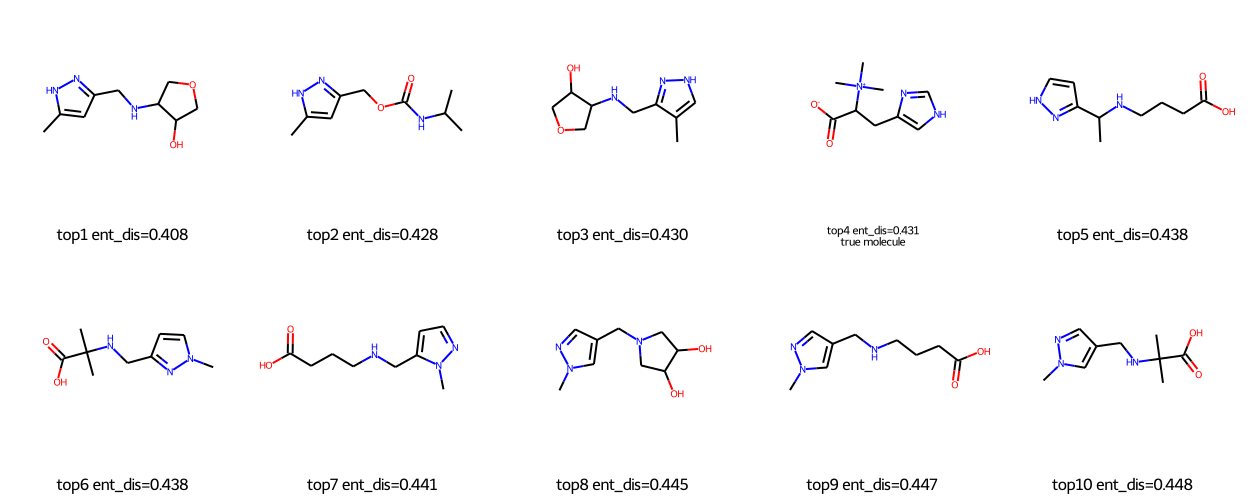

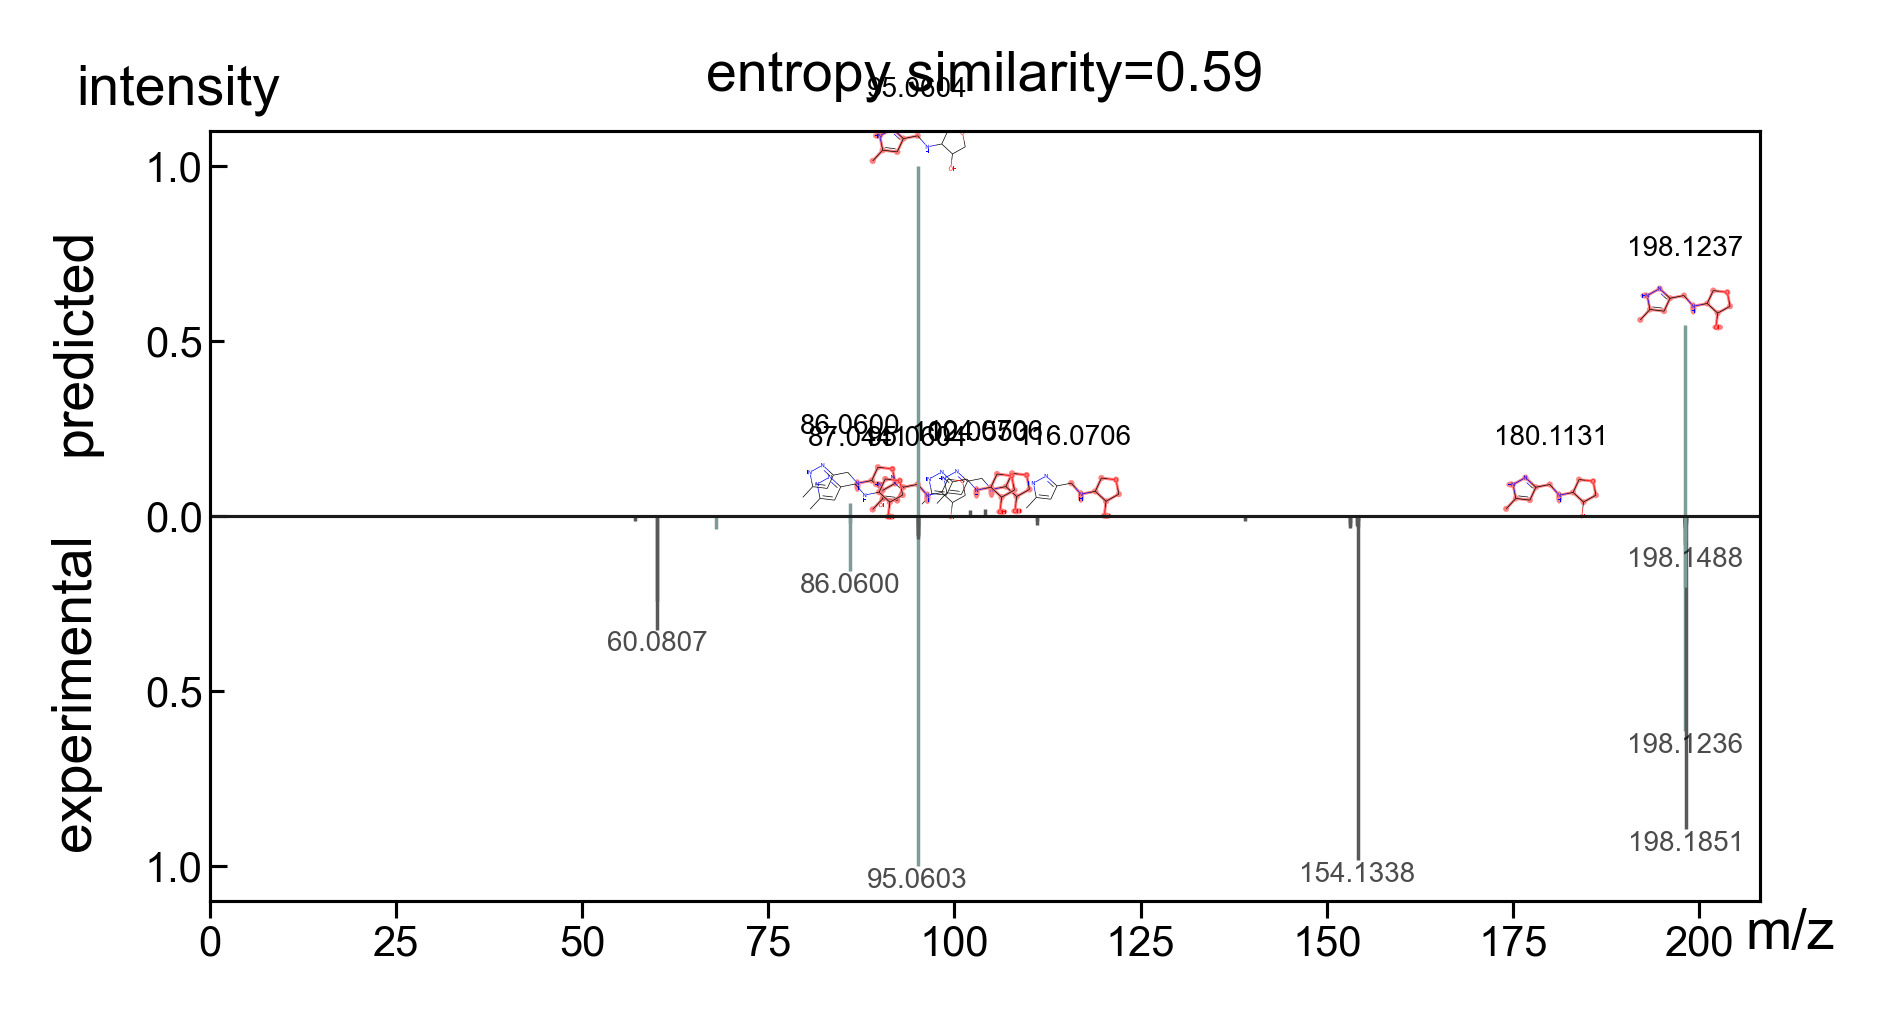

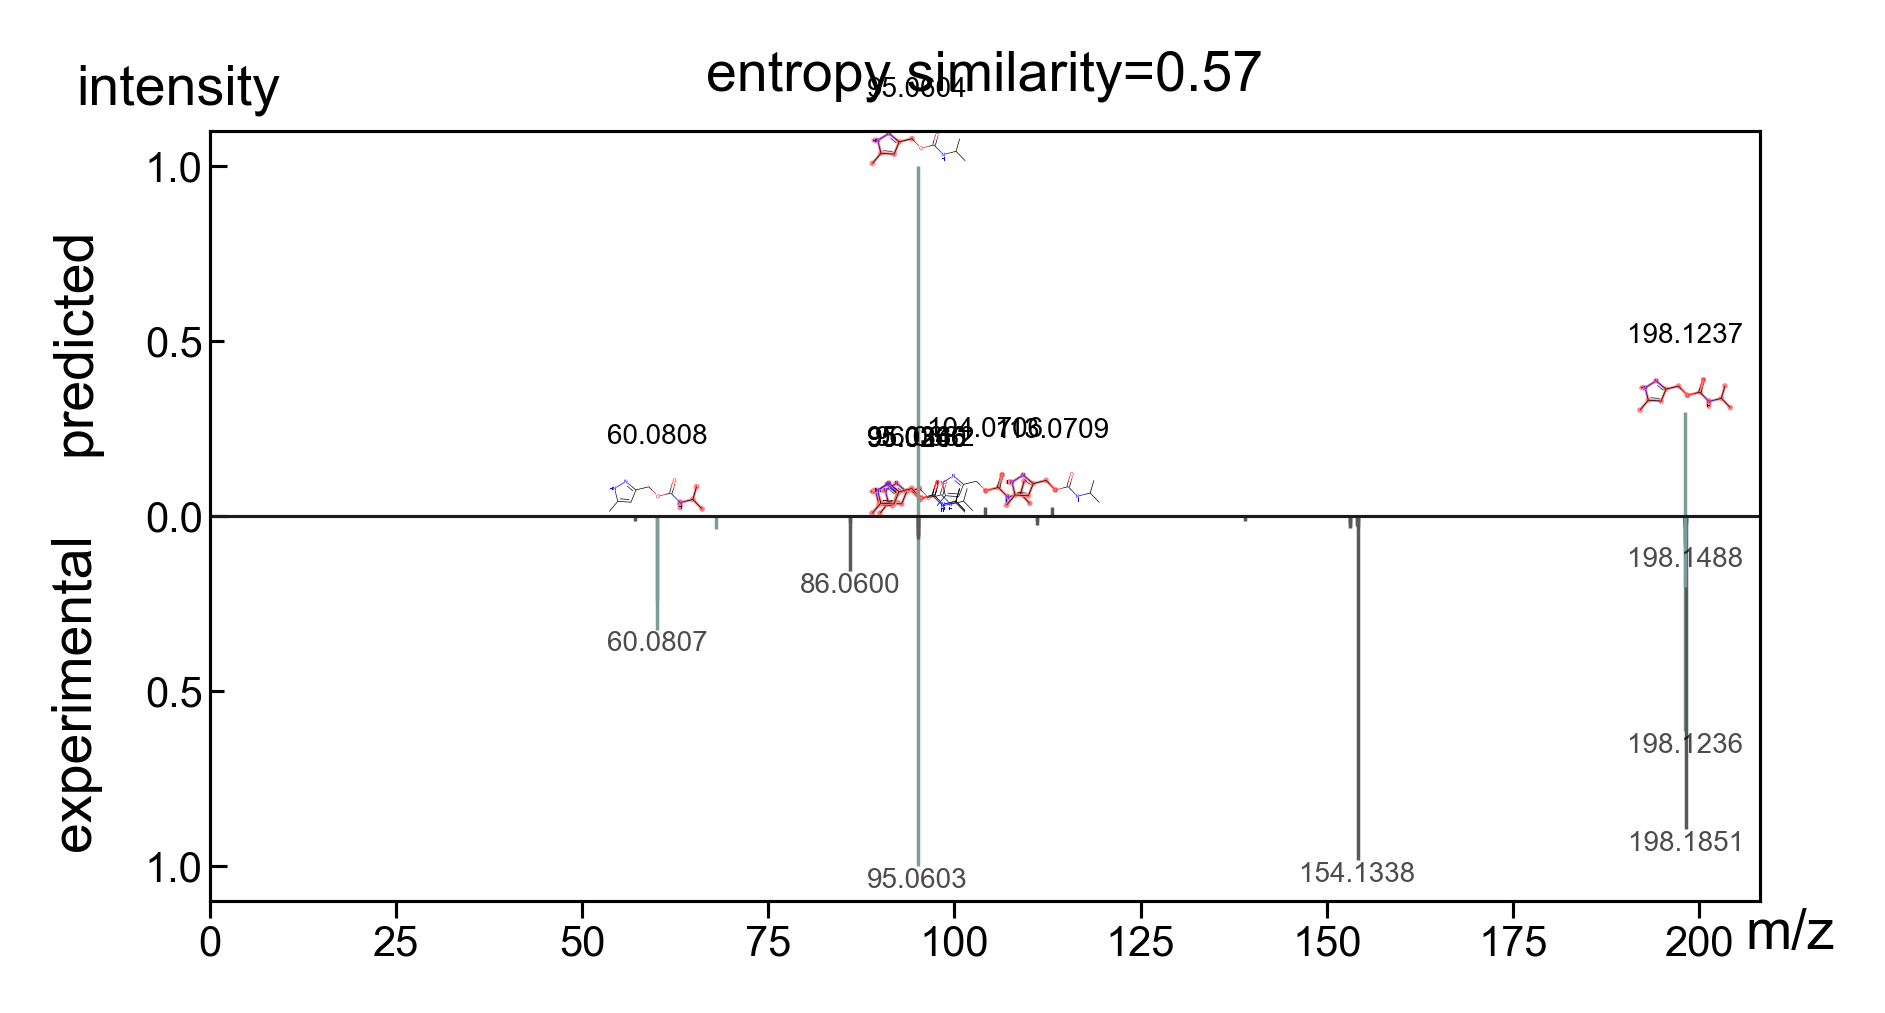

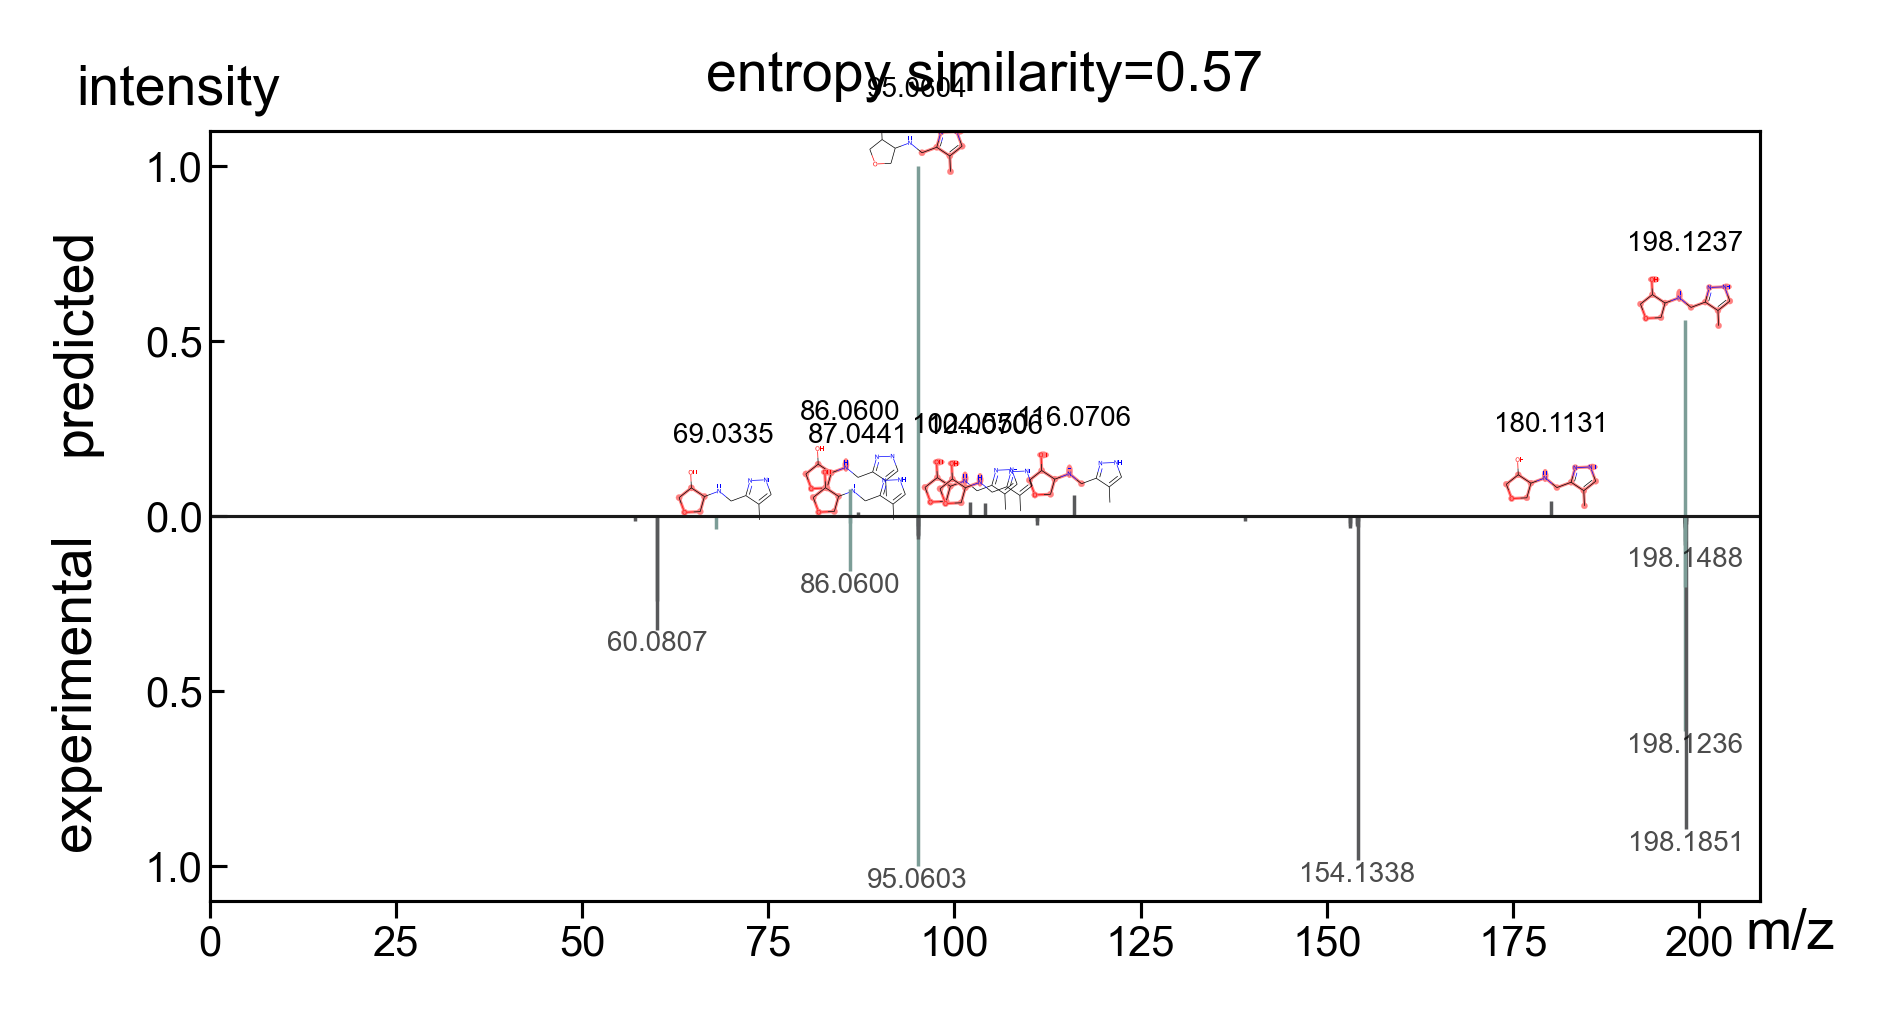

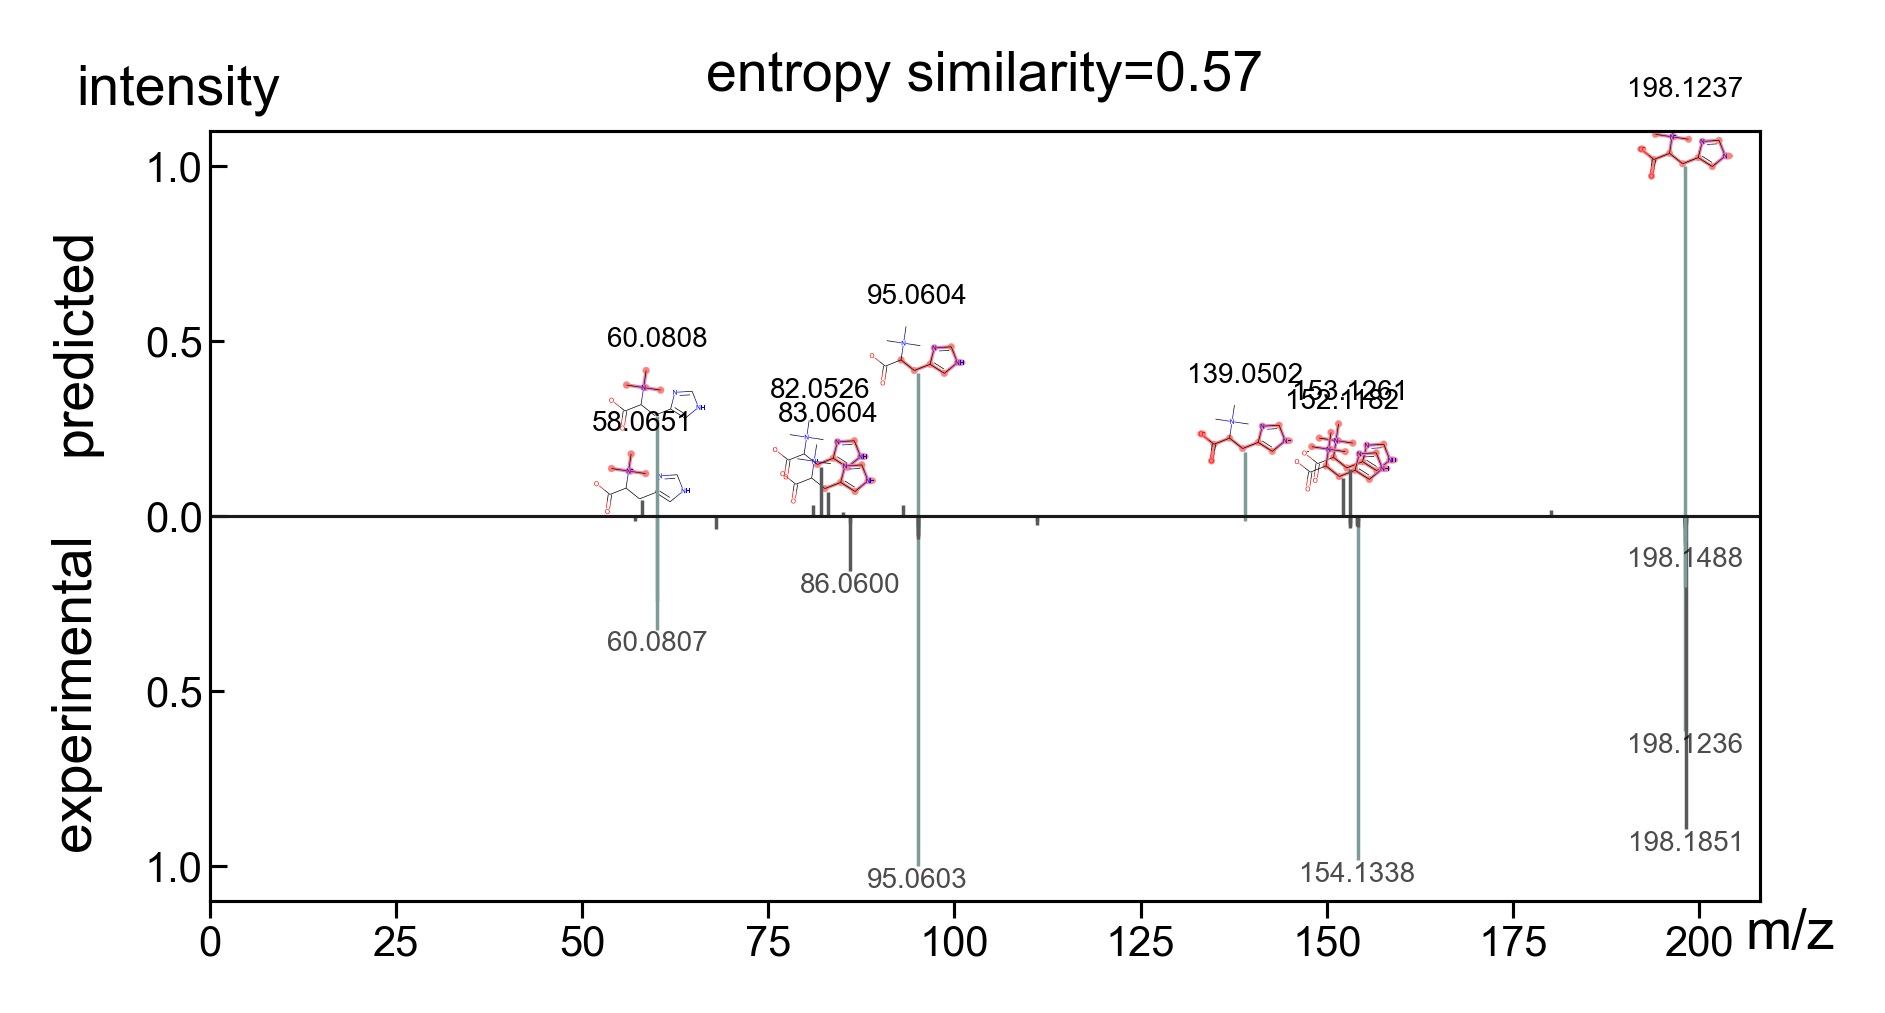

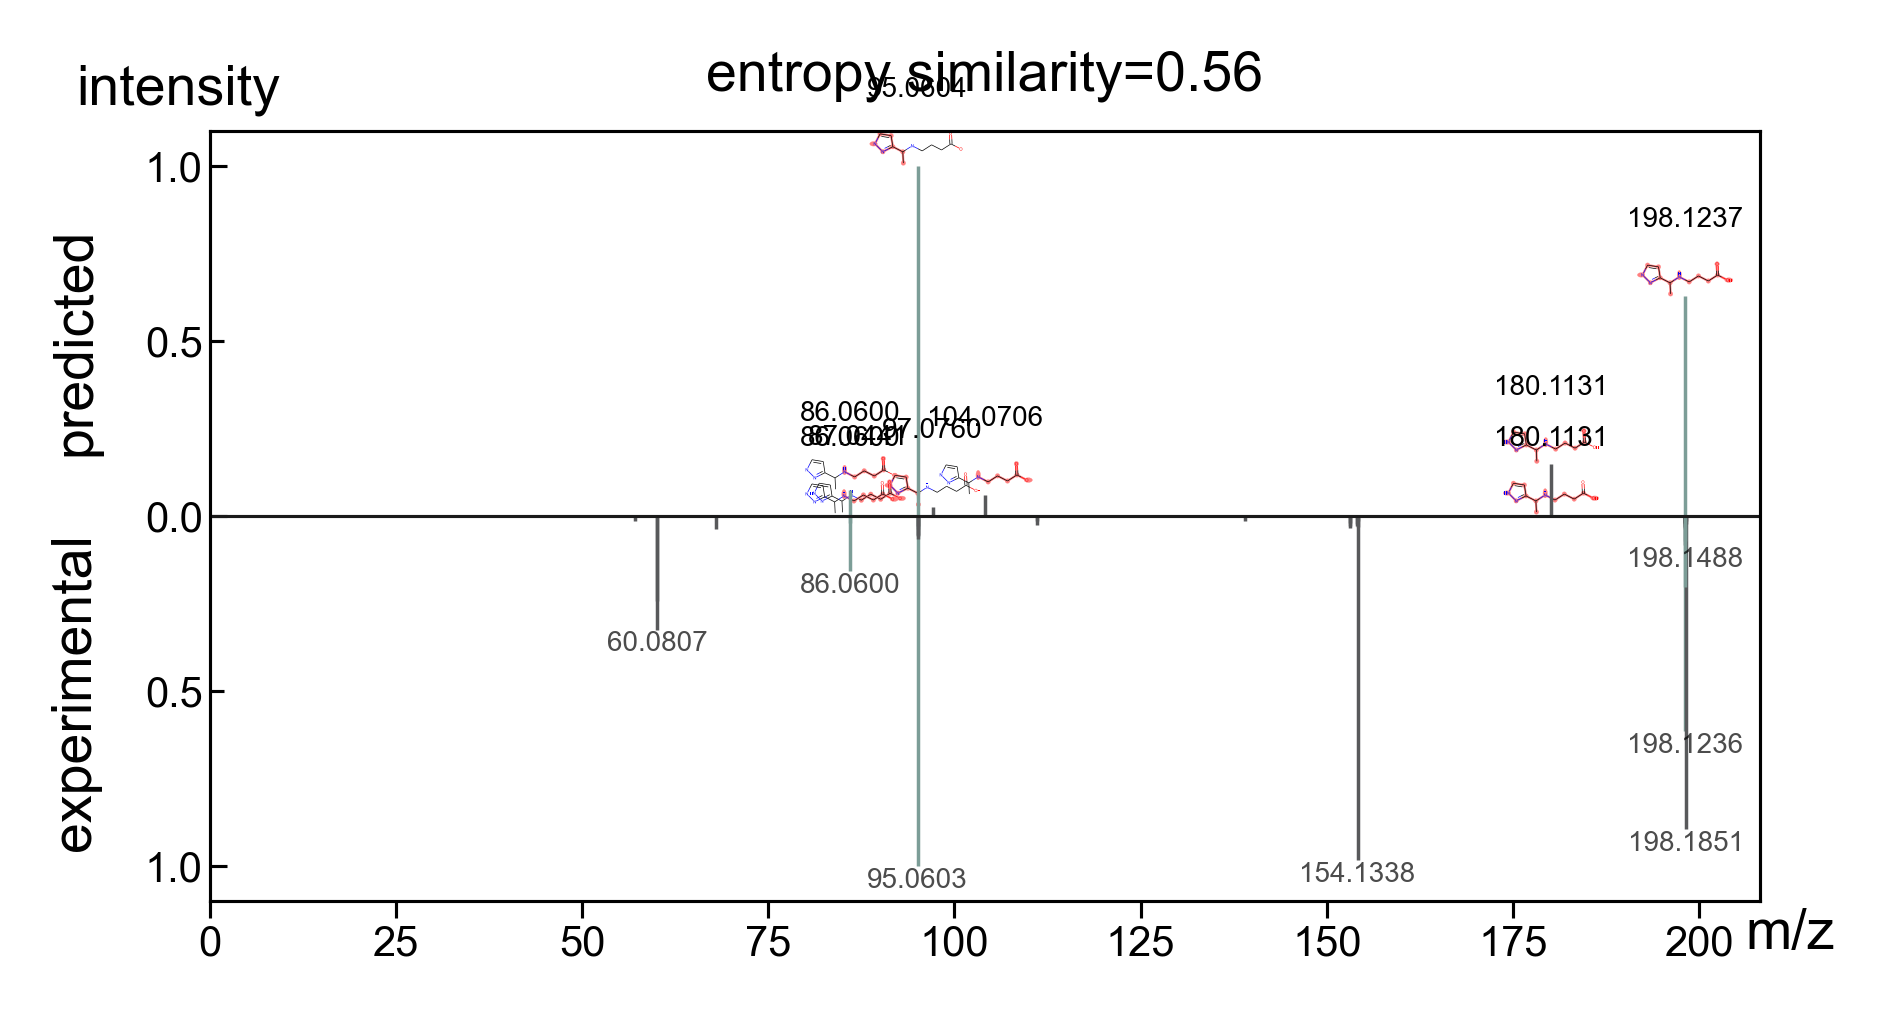

In [54]:
broad_elucidation('QI7142', 'C9H15N3O2', 'C[N+](C)(C)[CH](CC1=CN=CN1)C(=O)[O-]', 'Hercynine', False, False)

# LPC 19:0

[LPC_19_0] Found target mol at 2/55, ent_dist=0.371


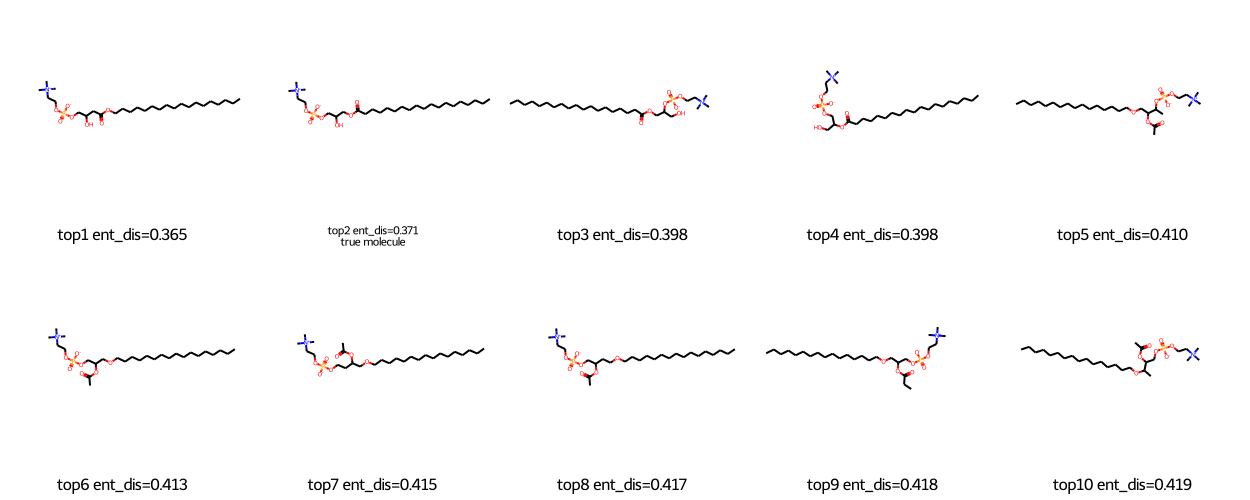

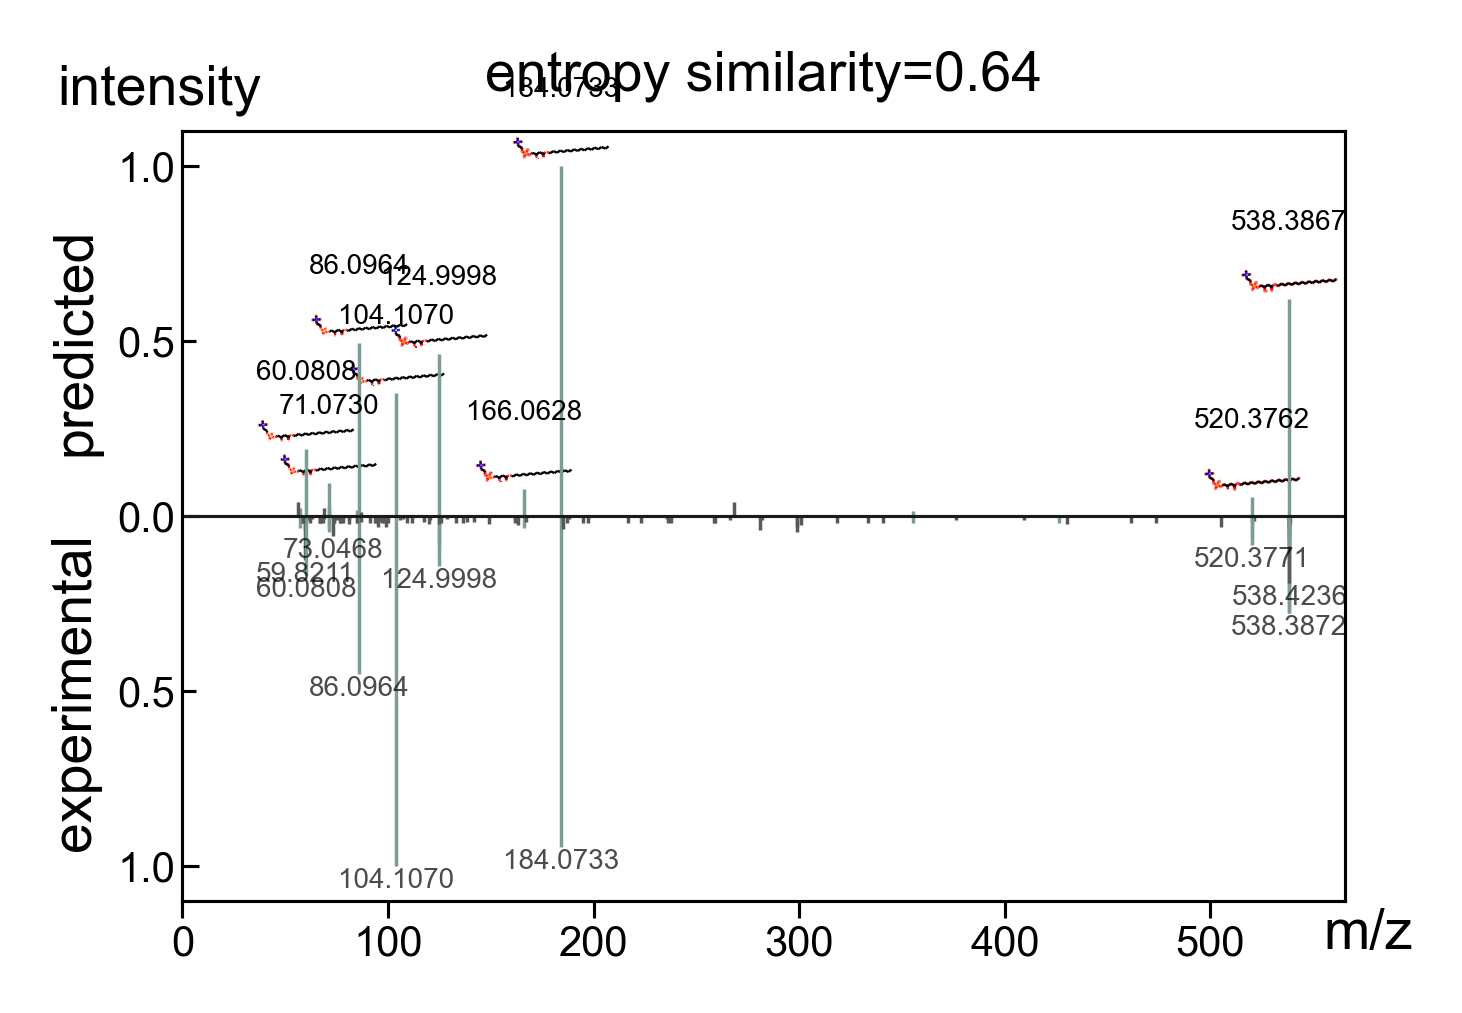

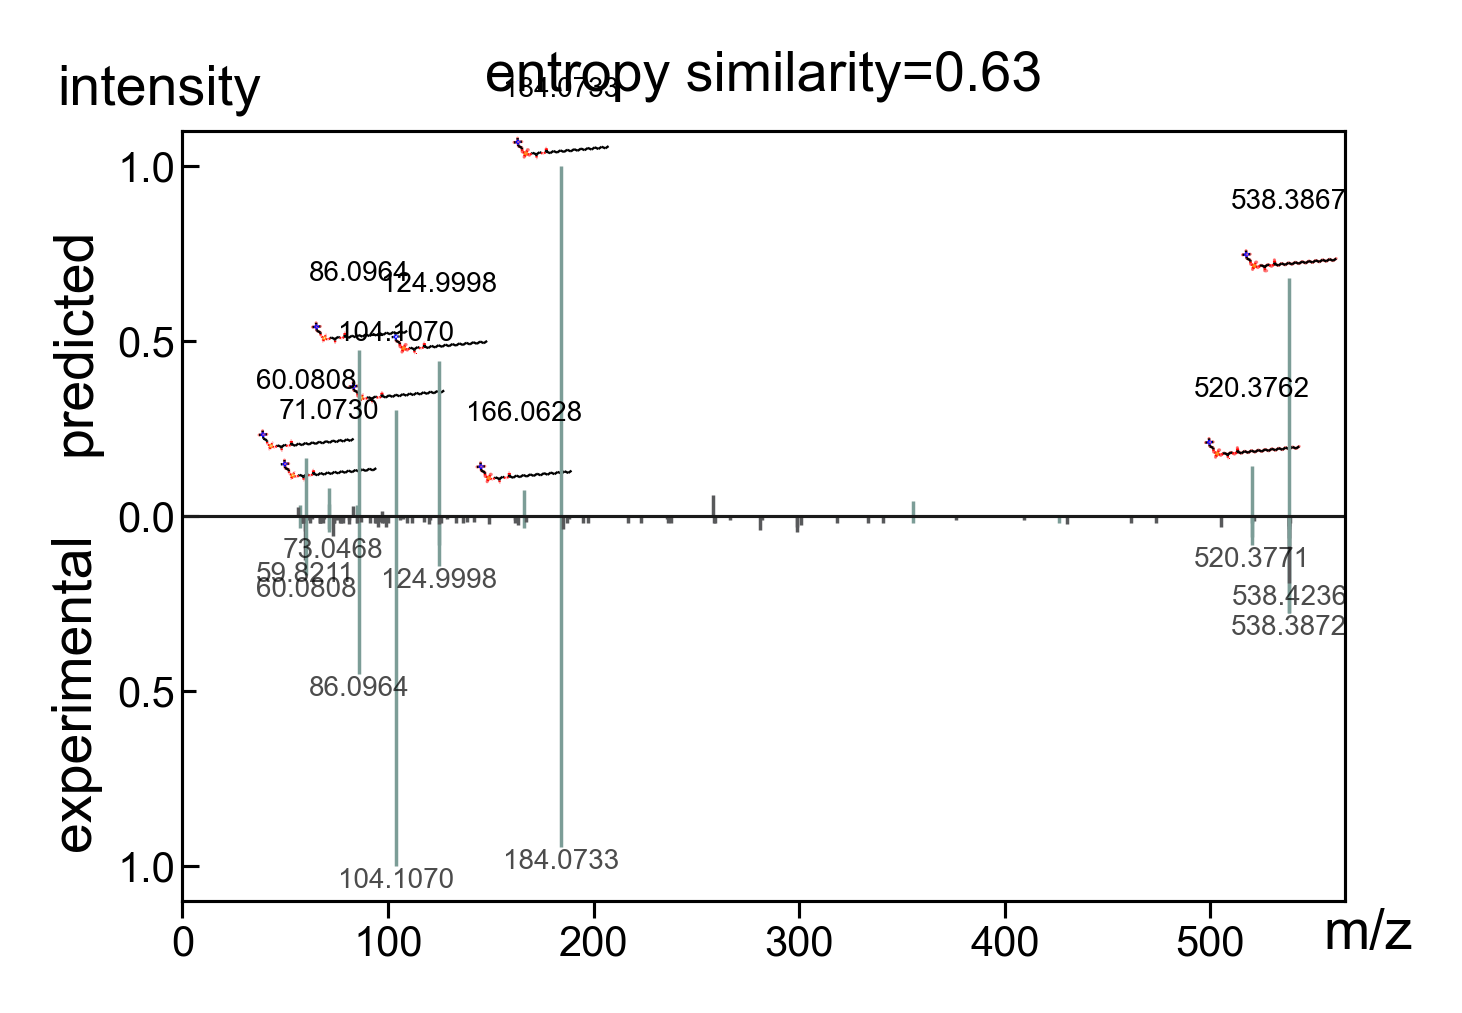

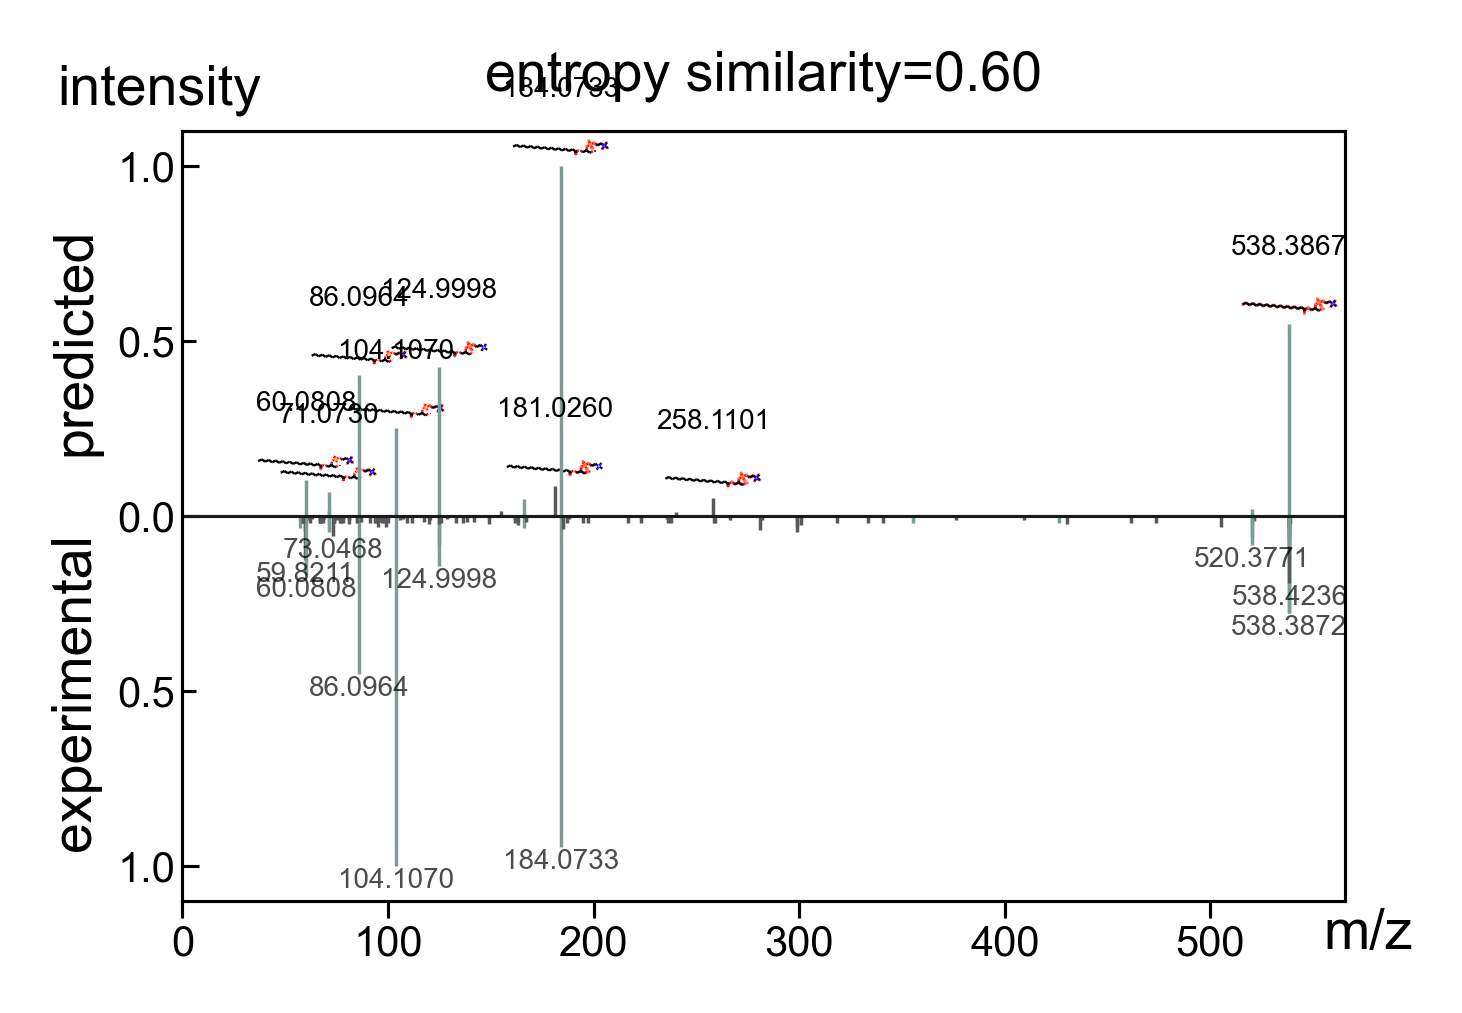

In [12]:
broad_elucidation('QI8894', 'C27H56NO7P', 'C[N+](CCOP([O-])(OCC(O)COC(CCCCCCCCCCCCCCCCCC)=O)=O)(C)C', 'LPC_19_0', True, False, vis_topk=3)

## OH-Tryptopha elucidation

In [50]:
broad_elucidation('mxp4310', 'C11H12N2O3', 'C1=CC2=C(C(=C1)O)C(=CN2)CC(C(=O)O)N', '4-Hydroxy Tryptophan', False, False)

CUDA_VISIBLE_DEVICES=0 /home/roger/miniforge3/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
               --batch-size 8 \
               --num-workers 6 \
               --dataset-labels /home/roger/.cache/ms-pred/iceberg-elucidation/f37234a52746f2d71b89a202d2708d09/cands_df_iceberg_elucidation.tsv \
               --sparse-out \
               --sparse-k 100 \
               --max-nodes 100 \
               --threshold 0.0 \
               --gen-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt \
               --inten-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt \
               --save-dir /home/roger/.cache/ms-pred/iceberg-elucidation/f37234a52746f2d71b89a202d2708d09 \
               --gpu \
               --adduct-shift


Global seed set to 42


2024-12-12 18:16:02,815 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/roger/.cache/ms-pred/iceberg-elucidation/f37234a52746f2d71b89a202d2708d09/cands_df_iceberg_elucidation.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
max_nodes: 100
num_bins: 15000
num_workers: 6
save_dir: /home/roger/.cache/ms-pred/iceberg-elucidation/f37234a52746f2d71b89a202d2708d09
seed: 42
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2024-12-12 18:16:03,125 INFO: Loaded gen / inten models from /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
2024-12-12 18:16:

  0%|          | 0/1156 [00:00<?, ?it/s]

2024-12-12 18:16:13,025 INFO: There are 36975 entries to process


Process SpawnPoolWorker-5:
  0%|          | 0/1156 [00:00<?, ?it/s]
Process SpawnPoolWorker-6:
Traceback (most recent call last):
Process SpawnPoolWorker-1:
  File "/home/roger/miniforge3/envs/ms-main/lib/python3.9/site-packages/multiprocess/pool.py", line 853, in next
Process SpawnPoolWorker-3:
    item = self._items.popleft()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred/src/ms_pred/dag_pred/predict_smis.py", line 270, in <module>
Process SpawnPoolWorker-4:
    predict()
  File "/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred/src/ms_pred/dag_pred/predict_smis.py", line 262, in predict
    common.chunked_parallel(all_batched_entries, producer_func, output_func=write_h5_func,
  File "/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred/src/ms_pred/common/parallel_utils.py", line 99, in chunked_parallel
    output_func(itertools.chain

KeyboardInterrupt: 

In [ ]:
broad_elucidation('mxp0141', 'C11H12N2O3', 'C1=CC2=C(C=C1O)C(=CN2)C[C@@H](C(=O)O)N', '5-Hydroxy Tryptophan', False, False)

In [ ]:
broad_elucidation('mxp4412', 'C11H12N2O3', 'C1=CC2=C(C(=C1)O)NC=C2CC(C(=O)O)N', '7-Hydroxy Tryptophan', False, False)

In [ ]:
broad_elucidation('mxp4411', 'C11H12N2O3', 'C1=CC2=C(C=C1O)NC=C2C[C@@H](C(=O)O)N', '6-Hydroxy Tryptophan', False, False)

In [ ]:
broad_elucidation('QI9873_all', 'C11H12N2O3', 'C1=CC2=C(C=C1)NC=C2C(O)[C@@H](C(=O)O)N', 'unknown', False, False)

### Modifinder

In [ ]:
meta1 = {
    'real_smi': r'C1=CC=C2C(=C1)C(=CN2)CC(C(=O)O)N',
    'cmpd_name': 'Tryptophan',
    'precursor': 205.0972,
    'ref_spec': 'nist_1188350',
}
meta2 = {
    'cmpd_name': 'OH-Tryptophan',
    'precursor': 221.0921,
    'ref_spec': '/home/roger/ms_collaborators/broad-Julian/spec_files/{}.ms'.format('mxp4310')
}
form_diff = '+O'

broad_config = copy.deepcopy(config)
broad_config['nce'] = True
broad_config['max_nodes'] = 500
broad_config['sparse_k'] = 500

# Run ICEBERG to predict spectra for mol1
result_path, pmz = iceberg_prediction([meta1["real_smi"]], [10, 20, 30, 40, 50], **broad_config)

imgs = modi_finder(
    form_diff, result_path, meta1["real_smi"],
    meta1["cmpd_name"], meta1["precursor"], meta1["ref_spec"], "nist",
    meta2["cmpd_name"], meta2["precursor"], meta2["ref_spec"], "ms",
    nce1=False, nce2=True,
    topk_peaks=15, return_thresh=0.1,
)

## Tripeptite

[Lys-Pro-Leu] Found target mol at 1/347, ent_dist=0.248


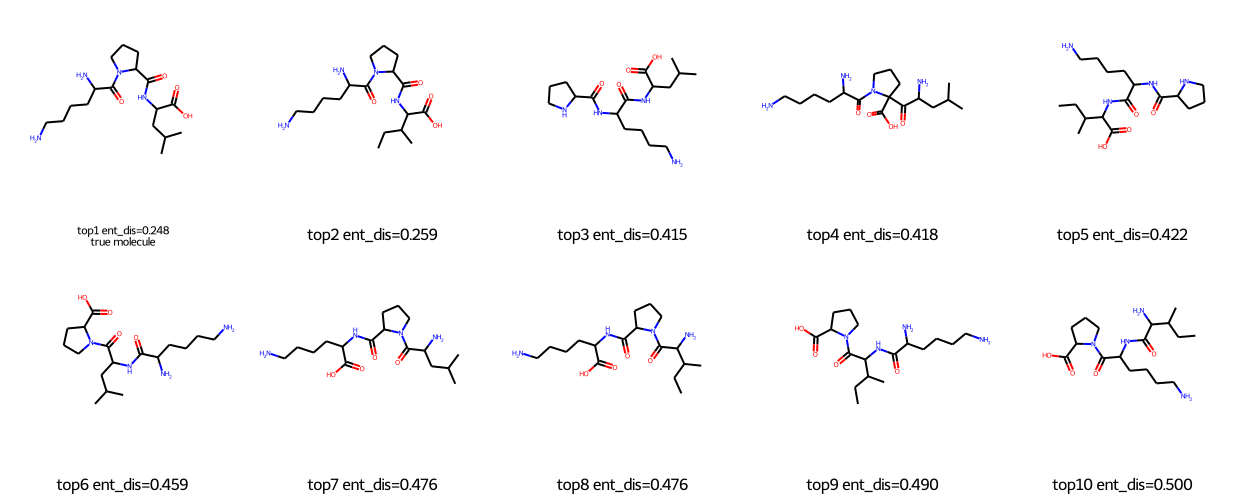

In [72]:
broad_elucidation('mxp4039', 'C17H32N4O4', r'CC(C)C[C@@H](C(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)N', 'Lys-Pro-Leu', False, False)

[Lys-Pro-Ile] Found target mol at 2/347, ent_dist=0.263


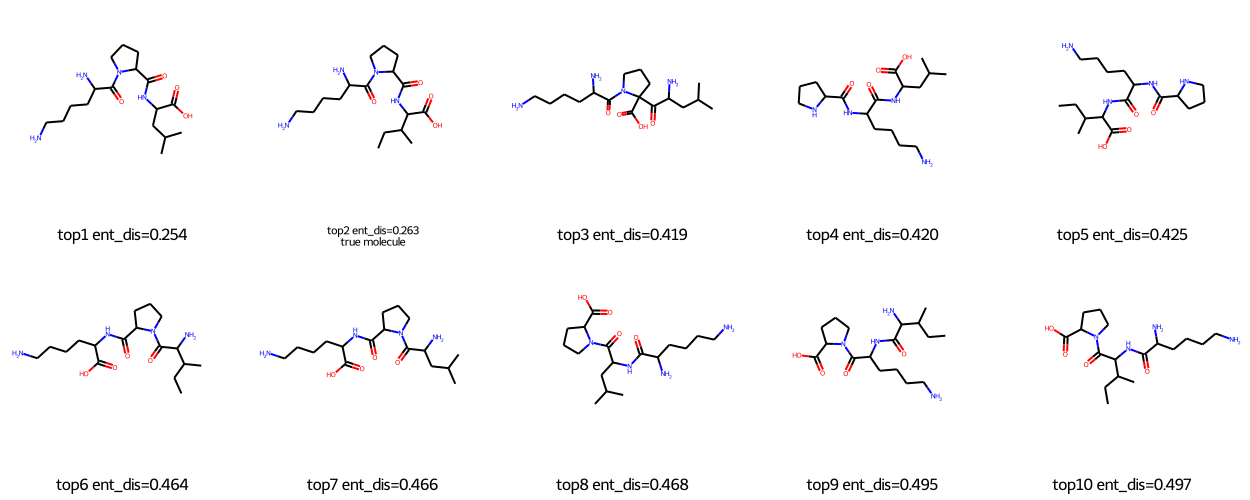

In [73]:
broad_elucidation('mxp4040', 'C17H32N4O4', r'CC[C@H](C)[C@@H](C(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)N', 'Lys-Pro-Ile', False, False)

[Leu-Pro-Lys] Found target mol at 1/347, ent_dist=0.238


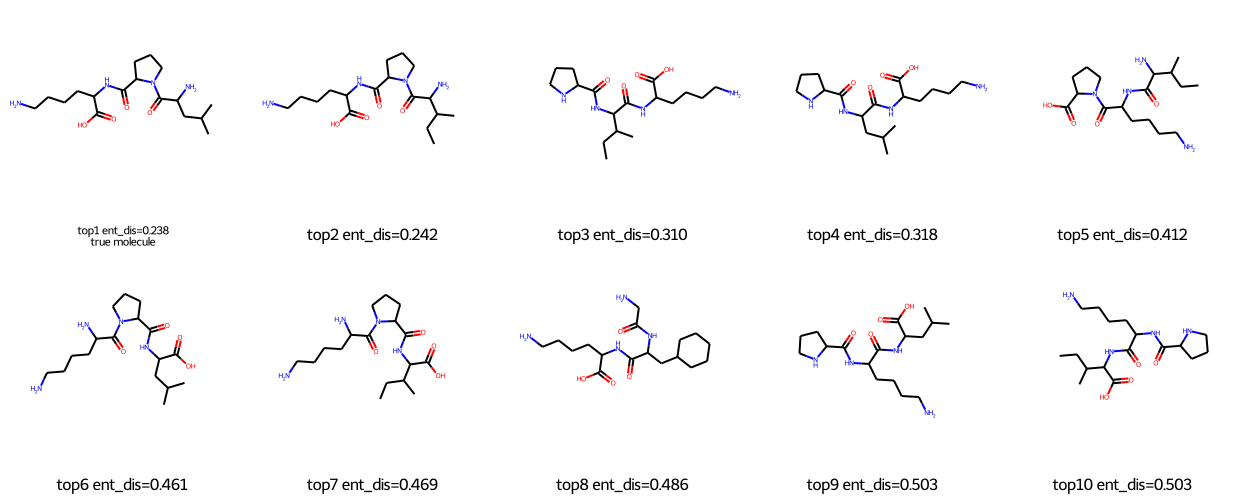

In [74]:
broad_elucidation('mxp4041', 'C17H32N4O4', r'CC(C)C[C@@H](C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCCCN)C(=O)O)N', 'Leu-Pro-Lys', False, False)

[Ile-Pro-Lys] Found target mol at 1/347, ent_dist=0.221


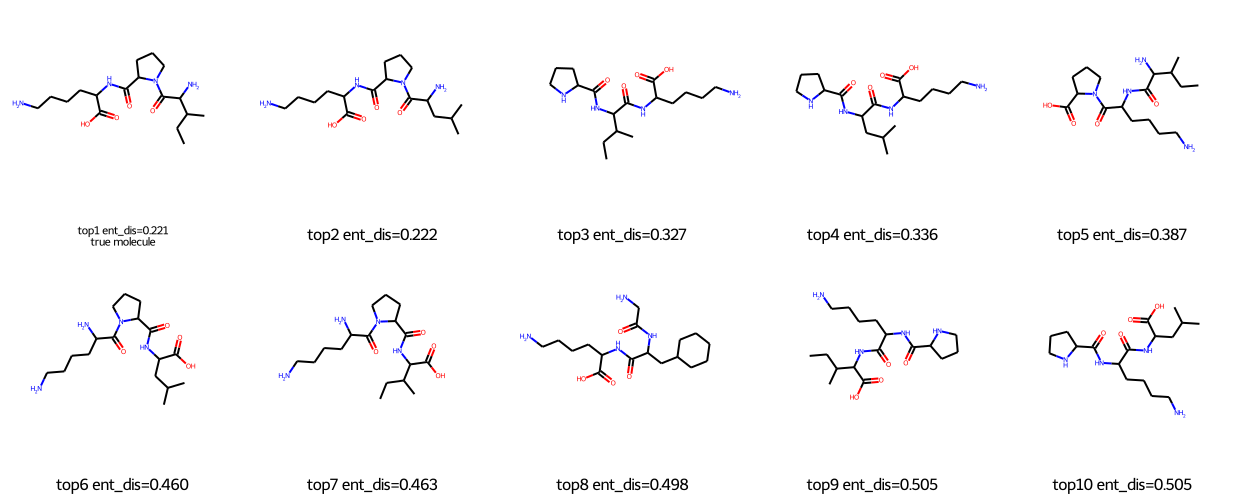

In [75]:
broad_elucidation('mxp4042', 'C17H32N4O4', r'CC[C@H](C)[C@@H](C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCCCN)C(=O)O)N', 'Ile-Pro-Lys', False, False)

[Unknown-Lys-Leu-Pro] Found target mol at 3/347, ent_dist=0.599


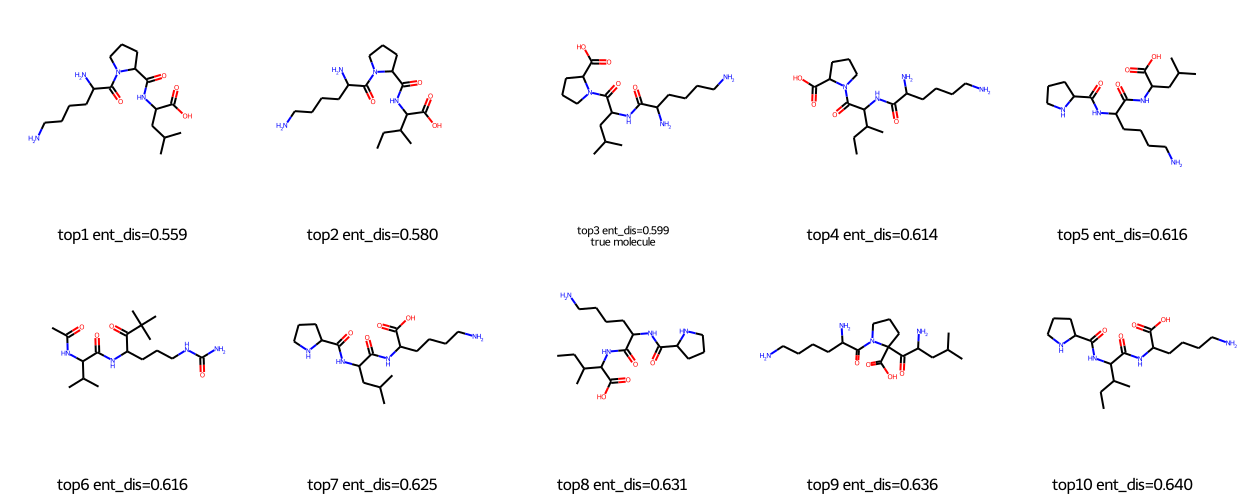

In [61]:
broad_elucidation('QI8422', 'C17H32N4O4', 'CC(C)CC(C(=O)N1CCCC1C(=O)O)NC(=O)C(CCCCN)N', 'Unknown-Lys-Leu-Pro', False, False)

## Food biomarkers

In [ ]:
broad_config = copy.deepcopy(config)
broad_config['nce'] = True # use nce for collision energy

# Get candidates
df = pd.read_csv('/home/roger/ms_collaborators/broad-Julian/24_0723_Compounds_to_generate_in_silico_MSMS.csv')
out_dir = Path('/home/roger/ms_collaborators/broad-Julian/foodbiomarker')
out_dir.mkdir(parents=True, exist_ok=True)

# fix formula mismatch
for idx, row in df.iterrows():
    df.at[idx, 'Chemical Formula'] = common.form_from_smi(row['SMILES'])

smiles = []
for idx, row in df.iterrows():
    smiles.append(common.rm_stereo(row['SMILES']))

result_path, pmz = iceberg_prediction(smiles, [10, 20, 30, 40, 50], **broad_config)

smiles, pred_specs, pred_frags = load_pred_spec(result_path, False)
for smi, pred_spec in zip(smiles, pred_specs):
    inchikey = common.inchikey_from_smiles(smi)
    out_arr = np.zeros((0, 3))
    for ev, spec in pred_spec.items():
        spec[:, 1] *= 100
        out_arr = np.concatenate(
            (out_arr,
             np.concatenate((spec, np.ones((spec.shape[0], 1)) * float(ev)), axis=-1)),
            axis=0
        )
    df = pd.DataFrame(data=out_arr, columns=['m/z', 'inten', 'ev'])
    df.to_csv(out_dir / f'{inchikey}.csv', index=False)
